# AIPI 590 - XAI | Assignment #1
### Hongxuan Li

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1-POk2dzc--FCb_HUF2wJ8Q5rH2ZBKLAL?pli=1#scrollTo=_bVEj5iWj1uO)

In [1]:
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "/content/AIPI590-XAI" # Change to your repo name
git_path = 'https://github.com/h0ngxuanli/AIPI590-XAI.git' #Change to your path
!git clone "{git_path}"


# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'assignment1/requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'assignment1/'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls


Cloning into 'AIPI590-XAI'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 9 (delta 0), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 10.00 KiB | 3.33 MiB/s, done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the followin

# Dependencies

In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader, Dataset

from datasets import load_dataset
from tqdm import tqdm
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/swyun/miniconda3/envs/ESM_GearNet_MD/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

device(type='cuda')

# Hyperparameters

In [13]:
# hyperparameters
checkpoint = 'IMAGENET1K_V1'
dataset_path = "songweig/imagenet_sketch"
batch_size = 32
patch_size = 50
learning_rate = 0.001
num_samples_per_class = 1
epochs = 10
num_proc = 12
target_class = 0 # tench, Tinca tinca

# Load Pre-trained Model

In [4]:
# load model
model = torchvision.models.resnet34(weights = checkpoint)
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Prepare Dataset
1. load data from huggingface "songweig/imagenet_sketch" which contains 50 * 1000 samples. 50 samples for 1000 classes in ImageNet
2. select 10 samples for each class to form 10000 data samples
3. transform data samples in the sampled dataset to enbale spatial robustness
4. create dataloader

In [5]:
# apply transformation to enable robustnesss of adversarial patch
def transform(example):
    image = example['image']

    # there exists grey image
    if image.mode == 'L':
        image = image.convert('RGB')

    transformations = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transformed_image = transformations(image)
    example['image'] = transformed_image
    return example

# convert huggingface dataset into dataloader
class ImageNetDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label


In [6]:
# load dataset
# 50 images for 1000 classes
dataset = load_dataset(dataset_path, num_proc = num_proc)

In [7]:
# Select a subset of data for each class
class_labels = dataset['train'].features['label'].names
class_counts = {label: 0 for label in class_labels}
sampled_indices = []
for index, example in enumerate(dataset['train']):
    label = class_labels[example['label']]

    if class_counts[label] < num_samples_per_class:
        sampled_indices.append(index)
    class_counts[label] += 1

len(sampled_indices)


1000

In [8]:
# transform selected 10000 images
subset = dataset['train'].select(sampled_indices)
subset = subset.map(transform)
subset.set_format(type='torch', columns=['image', 'label'])
subset


Dataset({
    features: ['image', 'label'],
    num_rows: 1000
})

In [9]:
subset = ImageNetDataset(subset)  
dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True)

# Initialize the patch as trainbale parameters

In [11]:
# initialize patch as trainable parameters
patch = torch.rand((3, patch_size, patch_size), requires_grad=True, device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([patch], lr=learning_rate)

# Train patch by fooling model with targart label

In [14]:
progress_bar = tqdm(total=len(dataloader) * epochs, unit='batch', desc='Training')

for epoch in range(epochs):
  epoch_loss = 0.0

  for images, labels in dataloader:
    # load original images
    images, _ = images.to(device), labels.to(device)
    targets = torch.full((images.size(0),), target_class, dtype=torch.long, device=device)


    # apply patch to orginal image
    patched_images = images.clone()
    patch_size = patch.size(1)
    image_size = 224
    max_x = image_size - patch_size
    max_y = image_size - patch_size
    fixed_start_x = max_x // 2  # Center the patch horizontally
    fixed_start_y = max_y // 2  #
    patched_images[:, :, fixed_start_x:fixed_start_x + patch_size, fixed_start_y:fixed_start_y + patch_size] = patch

    # start training
    outputs = model(patched_images)
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    progress_bar.set_postfix(epoch=epoch + 1, loss=loss.item())
    progress_bar.update(1)

    torch.save(patch, 'adversarial_patch.pth')
  avg_loss = epoch_loss / len(dataloader)
  print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

# progress_bar.close()

Training:  16%|█▌        | 32/200 [01:33<08:09,  2.91s/batch, epoch=7, loss=14.3]

Epoch [1/10], Loss: 14.1084


Epoch [2/10], Loss: 14.0542


Epoch [3/10], Loss: 13.9971


Epoch [4/10], Loss: 13.9377


Epoch [5/10], Loss: 13.8739


Epoch [6/10], Loss: 13.8080


Epoch [7/10], Loss: 13.7375


Epoch [8/10], Loss: 13.6629


Epoch [9/10], Loss: 13.5809


Epoch [10/10], Loss: 13.4916


# Visualize Patch

/tmp/ipykernel_3285801/2955650159.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load('adversarial_patch.pth')


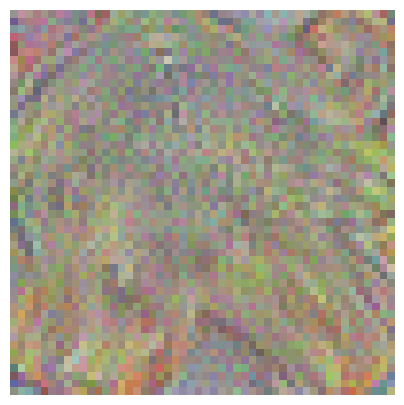

In [16]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


def denormalize(tensor):
    """
    Denormalize a tensor image with mean and standard deviation.
    """
    denorm = transforms.Normalize(
        mean=[-m/s for m, s in zip(MEAN, STD)],
        std=[1/s for s in STD]
    )
    return denorm(tensor)


# Define the mean and std used in your original transformation
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# load image
image = torch.load('adversarial_patch.pth')

# denormalize
image = denormalize(image)
image = image.cpu().detach()
image =  transforms.ToPILImage()(image)

# visualize
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
plt.show()

